In [ ]:
## hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 사용 등으로 수정해 보기

# hyperparameter 변경
# learning rate를 0.01 > 0.001로 수정

In [128]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [129]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

print(path_to_zip)
print(path)
# print(cats_and_dogs_filtered) 폴더 자체를 프린트할 수 없는 듯

/aiffel/.keras/datasets/cats_and_dogs.zip
/aiffel/.keras/datasets/cats_and_dogs_filtered


In [130]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [131]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [132]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [133]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [134]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [135]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [136]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [137]:
train_data_gen[0][0].shape
# train_data_gen[0][1].shape > 이미지 데이터의 레이블 정보

(16, 224, 224, 3)

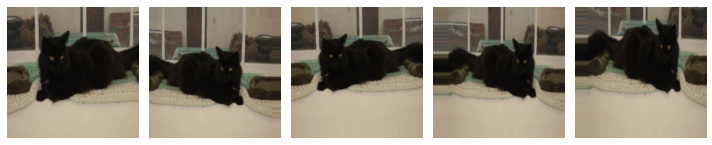

In [138]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [139]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [140]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


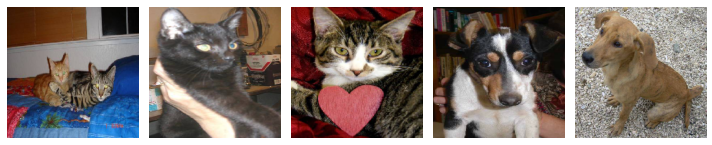

In [141]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [142]:
_[:5] # 정답 데이터

array([0., 0., 0., 1., 1.], dtype=float32)

In [143]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

# 변경된 부분: GlobalAveragePooling 사용
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# 변경된 부분: Dense 크기 축소
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 128, 64)      3692

In [145]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [146]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 35s 222ms/step - loss: 0.7161 - binary_accuracy: 0.5155 - val_loss: 0.6949 - val_binary_accuracy: 0.5030
Epoch 2/5
125/125 [==============================] - 27s 215ms/step - loss: 0.6895 - binary_accuracy: 0.5540 - val_loss: 0.6913 - val_binary_accuracy: 0.5390
Epoch 3/5
125/125 [==============================] - 27s 215ms/step - loss: 0.6907 - binary_accuracy: 0.5430 - val_loss: 0.6901 - val_binary_accuracy: 0.5270
Epoch 4/5
125/125 [==============================] - 28s 220ms/step - loss: 0.6914 - binary_accuracy: 0.5405 - val_loss: 0.6908 - val_binary_accuracy: 0.5280
Epoch 5/5
125/125 [==============================] - 27s 218ms/step - loss: 0.6901 - binary_accuracy: 0.5390 - val_loss: 0.6898 - val_binary_accuracy: 0.5350


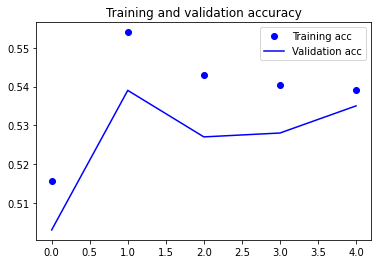

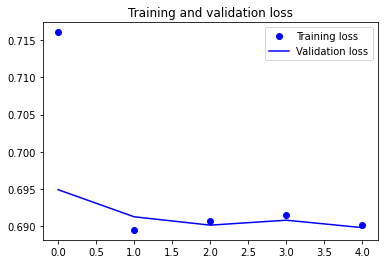

In [147]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##회고

##### 첫번째 미션인, VGG16 모델을 구현 수행 후, 사본 exercise_01_VGG16_edit 로 저장하여 재실행하니, 메모리가 부족하다는 오류 메시지가 떴음
"ResourceExhaustedError: OOM when allocating tensor with shape[131072,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]"

---
###### 1차 시도_32비트(fp32) 대신 16비트(fp16) 연산을 사용하여 메모리 절약 시도
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
> 메모리 문제 해결 안됨

###### 2차 시도_parameter 변경 : 이미지 사이즈를 256*256 > 224*224로 축소
batch_size = 16
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

batch_size 와 epochs은 충분히 작다고 판단하여 변경하지 않았음
> 메모리 문제 해결 안됨

###### 3차 시도_Dense 뉴런 축소 : 1024 > 512 / 512 > 256
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)
> 메모리 문제 해결 안됨

###### 4차 시도
_Flatten() 대신 GlobalAveragePooling2D()로 변경
x = tf.keras.layers.GlobalAveragePooling2D()(x)

_Dense 뉴런 재축소 : 512 > 256 / 256 > 128
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
> 메모리 문제 해결되었고, Accuracy 53% 이상 달성하였음